https://www.kdnuggets.com/2020/07/building-content-based-book-recommendation-engine.html <br>
https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b <br>
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

**Is Stemming or lemmatization necessary?!**

# Recommending Web Articles (Data Wrangling) 
By: MAHMOUD NAGY | MAY 2022

## Table of Contents
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li>  
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

**Your team leader requests from you**
- build a classifier for the articles that can use in the recommendation. <br>
- In addition to, grouping the articles under each category into multiple groups, for example: <br>
Articles with the **Engineering** category will be grouped into **4 groups** each group with a dummy name e.g. group1, group2, ... etc. 
    - group1 will be mapped into software design 
    - group2 will be mapped into mobile development 

**you are responsible only for the grouping, they need only:** <br>
<font color='blue'> Engineering </font>
- group1 = [Article#1, Article#5, Article#9, ... etc.]
- group2 = [Article#2, Article#15, Article#91, ... etc.]
- group3 = [Article#10, Article#25, Article#90, ... etc.]
- group4 = [Article#11, Article#4, Article#6, ... etc.] 

<font color='blue'> and other categories. <br>
.<br>
.<br>
.</font>


**Feel free to choose your classification algorithm and all the pre-processing needed on the data.**

The team shares with you a JSON file for a group of categorized articles as you will divide those articles into 3 groups: training data, validating data, and testing data. 
To measure the accuracy of each algorithm, at this level you will measure the accuracy by the percent of matching only.

**What we expected:**
A GitHub repository includes:
- Your **Notebook** with the code you used in cleaning and analyzing the data + your model + evaluation.
- **JSON file** for the clusters output (to each category).
- **PDF file** for the evaluation report that will be delivered to the leader (Make sure to mention all your steps in visualizing your results).

<a id='load'></a>
## Step 0: Load the Data
<ul>
<li><a href="#load"><b>Step 0: Load the Data</b></a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li>
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [1]:
from time import time
import pandas as pd
import numpy as np 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import re
import regex
import string

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# punkt is a nltk library tool for tokenizing text documents. When we use an old or a degraded version of nltk module we generally need to download the remaining data .
# You can do
# nltk.download('punkt')
# nltk.download('stopwords')

# Fix random seed
np.random.seed(42)

import importlib
importlib.reload(helper)

<module 'helper' from '/Users/mnagy99/jupyter/Knowledge Officer Assignment/Recommending Web Articles/helper.py'>

In [2]:
with open('recommending_web_articles.json') as f:
    my_json = json.load(f)
df = pd.DataFrame(my_json)
print(df.shape)
df.head()

(2481, 3)


,body,title,category
0,Protecting Netflix Viewing Privacy at Scale\r\...,Protecting Netflix Viewing Privacy at Scale,Engineering
1,Introducing Winston — Event driven Diagnostic ...,Introducing Winston - Event driven Diagnostic ...,Engineering
2,Performance & Usage at Instagram\r\n\r\nAt Ins...,Performance & Usage at Instagram,Engineering
3,The simple example of calculating and formatti...,Refactoring a javascript video store,Engineering
4,Billing applications have transactions that ne...,Netflix Billing Migration to AWS - Part III,Engineering


In [3]:
# df.body[0]

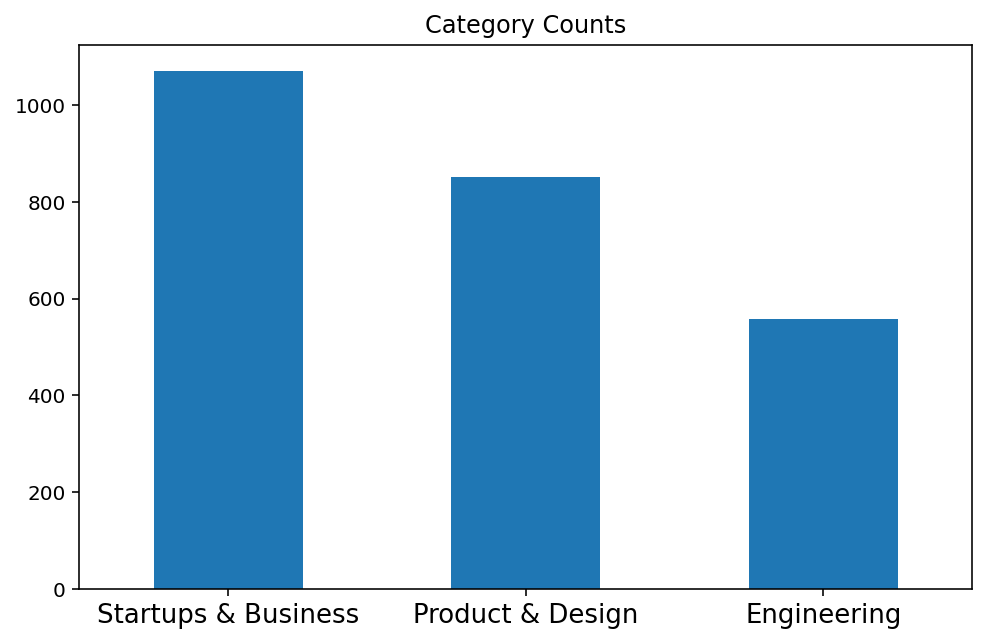

In [4]:
df.category.value_counts().plot(kind = 'bar', figsize = (8,5)  );
plt.title('Category Counts');
plt.xticks(rotation=0, size=13);

In [5]:
df.category.value_counts()

Startups & Business    1071
Product & Design        852
Engineering             558
Name: category, dtype: int64

<br>

**Add a Word Count Column**

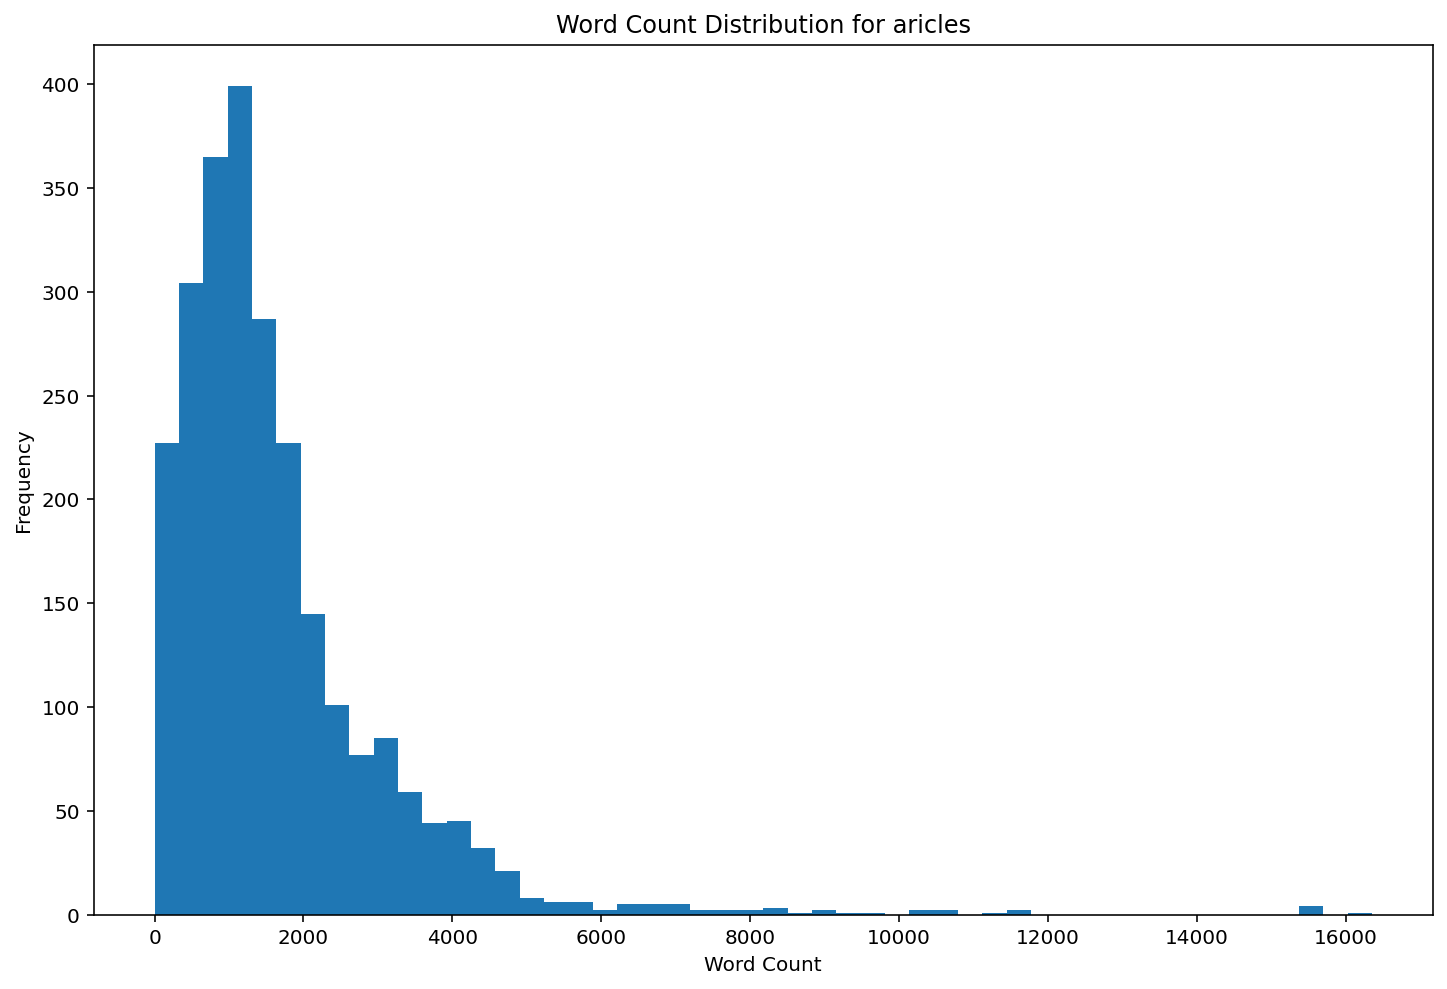

In [6]:
# Calculating the word count for articles
df['n_words'] = df['body'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['n_words'].plot(kind='hist', bins = 50, figsize = (12,8),
                   title='Word Count Distribution for aricles');
plt.xlabel('Word Count');

In [7]:
# Explore the articles with more than 10k words 
long_articles = df.query(" n_words > 10000")
long_articles

,body,title,category,n_words
23,"Modern web development has many challenges, an...",Basics of Web Application Security: Authentica...,Engineering,15376
26,"Modern web development has many challenges, an...",Basics of Web Application Security: Hash and S...,Engineering,15376
39,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\nWant to start ...,The Fundraising Wisdom That Helped Our Founder...,Startups & Business,10761
77,It's hard to say goodbye. A compilation of sta...,166 Startup Failure Post-Mortems,Startups & Business,16350
281,From financial fraud to just running out money...,Why Acceptance of Failure is Critical to Start...,Startups & Business,10150
337,"Last updated August 16, 2016\r\n\r\nComplexity...",Best Practices for Building a Microservice Arc...,Engineering,10726
370,"Modern web development has many challenges, an...",Basics of Web Application Security: Protect Us...,Engineering,15376
657,"Modern web development has many challenges, an...",Basics of Web Application Security: Authorize ...,Engineering,15376
1504,"00:00:00\n\n00:00:00\n\nIntroduction\n\nHi, I'...",Jennifer Johnson | Go-To-Market And Category D...,Product & Design,11489
1592,"We use ad-blockers as well, you know. We gotta...",Taking The Pattern Library To The Next Level,Product & Design,11515


### Sort the dataframe alphabetically by title

In [8]:
df.sort_values(by='title', inplace=True)
df.head()

,body,title,category,n_words
1482,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business,116
342,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,450
142,Interview with Fabian Reinartz and Björn Raben...,"""Transition to microservices while running und...",Engineering,752
1079,Why do many companies sprint from initial conc...,01 MarGo to Market Fit: Achieving Sustainable ...,Startups & Business,132
1240,1. Advisors\n\nChoose experienced advisors ear...,1. Advisors,Startups & Business,1470


<br>

<a id='nan'></a>
## Step 1: Check for NaNs
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan"><b>Step 1: Check for NaNs</b></a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li> 
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2481 entries, 1482 to 2118
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2481 non-null   object
 1   title     2481 non-null   object
 2   category  2481 non-null   object
 3   n_words   2481 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 96.9+ KB


In [10]:
# df[(df == '').any(axis=1)]
(df['n_words']==0).sum()

49

In [11]:
# Drop the words count column
df.drop(columns='n_words', inplace=True)

**Replace White Spaces with NaNs**

In [12]:
# df.replace('', np.nan, inplace=True)
# df.info()

In [13]:
# df.replace(' ', np.nan, inplace=True)
# df.info()

In [14]:
# ^ --> Starts with
# \s --> Returns a match where the string contains a white space character
# * --> Zero or more occurrences
# $ --> Ends with
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2481 entries, 1482 to 2118
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2432 non-null   object
 1   title     2481 non-null   object
 2   category  2481 non-null   object
dtypes: object(3)
memory usage: 77.5+ KB


In [15]:
df.isnull().sum()

body        49
title        0
category     0
dtype: int64

In [16]:
df.fillna('missing', inplace=True)

<br>

<a id='duplicate'></a>
## Step 2: Check for Duplicates
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate"><b>Step 2: Check for Duplicates</b></a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li>
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [17]:
df.duplicated().sum()

20

In [18]:
# drop duplicates in body, title and category
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

### check for body duplicates

In [19]:
df.body.duplicated().sum()

82

In [20]:
missing1 = "Sorry, that page doesn’t exist!\n\nYou can search Twitter using the search box below or return to the homepage."
missing2 = "Ooops... Error 404\n\nSorry, but the page you are looking for doesn't exist.\n\nYou can go to the HOMEPAGE"
df['body'].replace([missing1, missing2], 'page doesn’t exist!', regex=True, inplace=True)

In [21]:
repeated_bodies = df.body.value_counts()[df.body.value_counts() > 1].index
df[(df.body.isin(repeated_bodies)) & ~(df.body.isin(['missing', 'page doesn’t exist!']))].sort_values(by='body')

,body,title,category
2325,15 engineers.\n\nThat’s the size things start ...,"Making Engineering Team Communication Clearer,...",Startups & Business
2094,15 engineers.\n\nThat’s the size things start ...,"Making Engineering Team Communication Clearer,...",Engineering
964,Awesome - Most Cited Deep Learning Papers\n\nA...,awesome-deep-learning-papers/README.md at mast...,Engineering
1001,Awesome - Most Cited Deep Learning Papers\n\nA...,GitHub - terryum/awesome-deep-learning-papers:...,Engineering
2405,"By any measure, Instagram’s major milestones a...",Instagram Co-founder Mike Krieger on engineeri...,Startups & Business
2422,"By any measure, Instagram’s major milestones a...",How Instagram Co-founder Mike Krieger Took Its...,Startups & Business
1589,David Loftesness and Alexander Grosse know a t...,Fighting Factions: How Startups Can Scale With...,Startups & Business
1575,David Loftesness and Alexander Grosse know a t...,Fighting Factions: How Startups Can Scale With...,Startups & Business
572,Developing as a Product Manager\r\n\r\nBY JAME...,5 Paths To Your First Product Manager Role,Product & Design
959,Developing as a Product Manager\r\n\r\nBY JAME...,Developing as a Product Manager,Product & Design


<br>

**Drop all body duplicates (except for missing or doesn't exist values** <br>
<font color='red'> If we did this, we are going to lose some useful information (titles variation)</font>

In [22]:
# # df.drop_duplicates(subset='body')
# df = df[~df['body'].duplicated() | df['body'].isin(['missing', 'page doesn’t exist!'])].copy()

<br>

### check for title duplicates

In [23]:
df.title.duplicated().sum()

7

In [24]:
repeated_titles = df.title.value_counts()[df.title.value_counts() > 1].index
repeated_titles

Index(['Great help content starts with great questions',
       'Omnisearch Index Formats',
       'Why Trello Failed to Build a $1 Billion+ Business',
       'The Dirty Dozen: 12 KPIs You Must Know Before Pitching Your Startup',
       'Simplify Service Dependencies with Nodes', 'Optimizing Twitter Heron',
       'Learn More'],
      dtype='object')

In [25]:
df[df.title.isin(repeated_titles)]

,body,title,category
251,I spent over a decade as a product manager at ...,Great help content starts with great questions,Startups & Business
829,"So if the questions you ask your team, yoursel...",Great help content starts with great questions,Product & Design
1215,"What?\n\nAs you may know, the product owner or...",Learn More,Product & Design
749,The Strategy Canvas\n\nThe Strategy Canvas was...,Learn More,Product & Design
444,Infrastructure Omnisearch Index Formats By Yan...,Omnisearch Index Formats,Engineering
1579,page doesn’t exist!,Omnisearch Index Formats,Engineering
1540,page doesn’t exist!,Optimizing Twitter Heron,Engineering
1539,Open source Optimizing Twitter Heron By Karthi...,Optimizing Twitter Heron,Engineering
1541,page doesn’t exist!,Simplify Service Dependencies with Nodes,Engineering
445,Open source Simplify Service Dependencies with...,Simplify Service Dependencies with Nodes,Engineering


In [26]:
df[df.body.str.contains('page doesn’t exist!')]

,body,title,category
1854,page doesn’t exist!,5 Steps To Successful Purpose-Driven PR,Startups & Business
1579,page doesn’t exist!,Omnisearch Index Formats,Engineering
1540,page doesn’t exist!,Optimizing Twitter Heron,Engineering
1541,page doesn’t exist!,Simplify Service Dependencies with Nodes,Engineering
2026,page doesn’t exist!,The Making of a Great Strategic Narrative,Product & Design
1943,page doesn’t exist!,The Seven Habits of Tech-Savvy Teams,Startups & Business


<br>

**drop rows where title is repeated and the page does not exist or missing**

In [27]:
# drop rows where title is repeated and the page does not exist or missing
df = df[~((df.title.isin(repeated_titles)) & (df.body.isin(['page doesn’t exist!', 'missing'])))].copy()
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head(1)

(2457, 3)


,body,title,category
0,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2457 non-null   object
 1   title     2457 non-null   object
 2   category  2457 non-null   object
dtypes: object(3)
memory usage: 57.7+ KB


In [29]:
repeated_titles2 = df.title.value_counts()[df.title.value_counts() > 1].index
repeated_titles2

Index(['Great help content starts with great questions',
       'Why Trello Failed to Build a $1 Billion+ Business', 'Learn More'],
      dtype='object')

In [30]:
df[df.title.isin(repeated_titles2)]

,body,title,category
778,I spent over a decade as a product manager at ...,Great help content starts with great questions,Startups & Business
779,"So if the questions you ask your team, yoursel...",Great help content starts with great questions,Product & Design
1262,"What?\n\nAs you may know, the product owner or...",Learn More,Product & Design
1263,The Strategy Canvas\n\nThe Strategy Canvas was...,Learn More,Product & Design
2344,"In 2011, Joel Spolsky launched his company Fog...",Why Trello Failed to Build a $1 Billion+ Business,Startups & Business
2345,Why Trello Failed to Build a $1 Billion+ Busin...,Why Trello Failed to Build a $1 Billion+ Business,Startups & Business


> **NOTE:**
>- Currency sympols --> Startups & Business

In [31]:
# df.iloc[np.r_[778, 779]].body.value_counts()

**Drop the "Learn More" Title**

In [32]:
df = df[~(df.title == 'Learn More')].copy()

**Drop Remaining Duplicated Titles** <br>
If we dropped them we'll lose some information, since they have different bodies

In [33]:
# df.drop_duplicates(subset='title', inplace=True)

<br>

<a id='short'></a>
## Step 3: Text Preprocessing
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short"><b>Step 3: Check short Titles</b></a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li> 
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [34]:
# check short titles
short_title = [t for t in df.title if len(t.split()) < 3]
df[df.title.isin(short_title)]

,body,title,category
4,1. Advisors\n\nChoose experienced advisors ear...,1. Advisors,Startups & Business
267,The Affordable Care Act is far from perfect–fo...,Affordable Care,Startups & Business
295,Over the last year or two I have been explorin...,Applying OKRs,Startups & Business
334,We tell startups all the time that they have t...,Before Growth,Startups & Business
341,\n\n\n\n\n\n\n\nMay 2001\n\n\n\n(This article ...,Being Popular,Engineering
359,"tags:\r\n\r\nDuring my career, I've heard many...",Bliki: FunctionLength,Engineering
360,tags:\r\n\r\nSometimes when I work with some d...,Bliki: HiddenPrecision,Engineering
361,tags:\n\nSynthetic monitoring (also called sem...,Bliki: SyntheticMonitoring,Engineering
362,"tags:\r\n\r\nWhen programming, I often find it...",Bliki: ValueObject,Engineering
364,"Over the last five years, there has been an in...",Board Members,Startups & Business


> - **OKRs** stand for “Objectives and Key Results.” It is a collaborative goal-setting methodology used by teams and individuals to set challenging, ambitious goals with measurable results. OKRs are how you track progress, create alignment, and encourage engagement around measurable goals.
> - **LSTM** (Long short-term memory) is an artificial neural network used in the fields of artificial intelligence and deep learning.

In [35]:
titles_to_drop = ['cancel reply', 'notdd', 'quora', 'geek.ly']
df = df[~(df.title.isin(titles_to_drop))].copy()

> It would be better if we have the time to look at the articles and give them representative titles, rather than just dropping them.

<br>

<a id='preprocess'></a>
## Step 4: Text Preprocessing
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess"><b>Step 4: Text Preprocessing</b></a></li> 
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

**There are two methods:**
- We can add a clean_text column in the data, then use string methods
- or we can extract features, then drop the unwanted columns

## Normalization
1. Convert all text to lower case
2. Remove Punctuations
3. Remove Stop Words
4. Remove Emojis
5. Remove Non-ASCII Characters

**1. Convert all text to lower case**

In [36]:
# 1. Convert all text to lower case
df[['title_clean', 'body_clean']] = df[['title', 'body']].applymap(lambda x: x.lower())

<br>

**remove underscores**

In [37]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].\
applymap(lambda x: x.replace('_', ' '))
time()- t0

0.018484830856323242

<br>

https://stackoverflow.com/questions/66415390/how-to-remove-words-which-contains-same-character-more-number-of-time

**Remove words which contains same character more than twice**

In [38]:
re.sub(r"(.)\1{2,}\w*", "", 'aaaaaall kinds', flags=re.I)

' kinds'

In [39]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper.remove_repeated_chars)
time()- t0

1.2575621604919434

<br>

https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

**2. Remove Punctuations and words with less than 3 characters**

In [40]:
# \w matches a letter, digit, or underscore
# \d --> Digits
# + --> One or more occurrences
# * --> Zero or one occurrences
# {} --> Exactly the specified number of occurrences
# {2,} --> Two or more occurrences
# \p{Sc} --> Currency Symbols
# We need to keep Currency sympols as they are strongly related to Startups & Business

regex.findall(r'\w{3,}|\p{Sc}', 'Why Trello Failed to Build a $1 Billion+ Business')

['Why', 'Trello', 'Failed', 'Build', '$', 'Billion', 'Business']

In [41]:
# This function keeps only letters, digits, underscores, and currency symbols
# Also it removes any word less than 3 characters
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper.remove_punctuation)
time()- t0

1.62282395362854

In [42]:
# print(string.punctuation) 
# # I removed currency, plus , percent and exclamation 
# # Since I believe they would be useful features
# string.punctuation.replace('$', '').replace('+', '').replace('%', '').replace('!','').replace('!','?')

In [43]:
# # 2. Remove Punctuations
# def remove_punctuations(s):
#     return s.translate(str.maketrans('', '', '"#&\'()*,-./:;<=>@[\\]^_`{|}~'))

# t0 = time()
# df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(remove_punctuations)
# time()- t0

In [44]:
df[df['title_clean'].str.contains('billion')].title_clean.value_counts().head()

why trello failed build $ billion business                    2
extraordinary business lessons from self made billionaires    1
billion dollar ideas how know when you see one                1
delivering billions messages exactly once                     1
how discord indexes billions messages                         1
Name: title_clean, dtype: int64

<br>

**3. Remove Stop Words**

In [45]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper.remove_stop_words)
time()- t0

1.202406883239746

<br>

**4. Remove Emojis**

In [46]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper.remove_emojis)
time()- t0

0.4555220603942871

<br>

**5. Remove Non-ASCII Characters**

https://stackoverflow.com/questions/14953441/strip-non-ascii-chars-but-allow-currency-symbols <br>
https://www.regular-expressions.info/unicode.html#prop

In [47]:
# ASCII Characters
''.join(chr(i) for i in range(128))

'\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f'

In [48]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper._removeNonAscii)
time()- t0

1.6105420589447021

<br>

<br>

**remove all text starting with numbers**

https://stackoverflow.com/questions/6664151/difference-between-b-and-b-in-regex

In [49]:
# . --> any character
# $ --> ends with
# \s --> space
regex.sub(r'\d+\w*\b', ' ', 'Why Trello Failed to Build a $100k Billion+ Business')

'Why Trello Failed to Build a $  Billion+ Business'

In [50]:
regex.sub(r'\d+\w*\b', '', '01_ MarGo to Market Fit: Achieving Sustainable')

' MarGo to Market Fit: Achieving Sustainable'

In [51]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper.remove_numbers)
time()- t0

0.16374564170837402

In [52]:
print(df.shape)
df.head()

(2454, 5)


,body,title,category,title_clean,body_clean
0,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business,make entrepreneurial journey sufficiently epic...,founder institute startup tips tricks series g...
1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,size microservice size team building,jaxenter microservices helped achieve goals av...
2,Interview with Fabian Reinartz and Björn Raben...,"""Transition to microservices while running und...",Engineering,transition microservices running full steam easy,interview fabian reinartz bjrn rabenstein soun...
3,Why do many companies sprint from initial conc...,01 MarGo to Market Fit: Achieving Sustainable ...,Startups & Business,margo market fit achieving sustainable growth,many companies sprint initial concept product ...
4,1. Advisors\n\nChoose experienced advisors ear...,1. Advisors,Startups & Business,advisors,advisors choose experienced advisors early inc...


<br>

In [53]:
# importlib.reload(helper)

**2. Remove words with less than 3 characters (Again after cleaning)**

In [54]:
# b --> blank | word break
regex.sub(r'\b\w{,2}\b', '', 'Why Trello Failed to Build a $1 Billion+ Business')

'Why Trello Failed  Build  $ Billion+ Business'

In [55]:
helper.remove_short_words('Why Trello Failed to Build a $1 Billion+ Business')

'Trello Failed Build Billion+ Business'

In [56]:
t0 = time()
df[['body_clean', 'title_clean']] = df[['body_clean', 'title_clean']].applymap(helper.remove_short_words)
time()- t0

0.35280609130859375

<br>

In [57]:
# df.title_clean.value_counts().head(10)

**Check for the repeated titles after cleaning**

In [58]:
# Check for the repeated titles after cleaning
repeated_titles3 = df.title_clean.value_counts()[df.title_clean.value_counts() > 1].index
repeated_titles3

Index(['attacking machine learning adversarial examples', 'internet economy',
       'must reads startup people',
       'photo editing generative adversarial networks part', 'growth',
       'play dead snakes kill projects kill',
       'trello failed build billion business',
       'start right foot build customer advisory board',
       'humans hate spun practice radical honesty woman defined netflix culture',
       'weeks goldilocks product timeframes',
       'track facilitate engineers flow states simple',
       'data fast data four weeks reactive programming changing world part',
       'making engineering team communication clearer faster better',
       'pitch immeasurable leadership tips',
       'great help content starts great questions',
       'important questions scoping', 'grow faster pause questions stripe',
       'netflix billing migration part'],
      dtype='object')

In [59]:
df[df.title_clean.isin(repeated_titles3)]

,body,title,category,title_clean,body_clean
147,6 weeks: why it’s the Goldilocks of product ti...,6 weeks: why it's the Goldilocks of product ti...,Product & Design,weeks goldilocks product timeframes,weeks goldilocks product timeframes process pr...
148,"Process for a product team can be suffocating,...",6 weeks: why it’s the Goldilocks of product ti...,Product & Design,weeks goldilocks product timeframes,process product team suffocating process liber...
312,Adversarial examples are inputs to machine lea...,Attacking Machine Learning with Adversarial Ex...,Engineering,attacking machine learning adversarial examples,adversarial examples inputs machine learning m...
313,missing,Attacking machine learning with adversarial ex...,Engineering,attacking machine learning adversarial examples,missing
334,We tell startups all the time that they have t...,Before Growth,Startups & Business,growth,tell startups time grow quickly true good advi...
597,This advice for working on the right projects ...,Don't Play with Dead Snakes - Kill Projects Be...,Startups & Business,play dead snakes kill projects kill,advice working right projects jettisoning wron...
598,This advice for working on the right projects ...,Don't Play with Dead Snakes — Kill Projects Be...,Startups & Business,play dead snakes kill projects kill,advice working right projects jettisoning wron...
719,Part 1: Reactive Manifesto’s Invisible Hand\r\...,From Big Data to Fast Data in Four Weeks or Ho...,Engineering,data fast data four weeks reactive programming...,part reactive manifesto invisible hand first s...
720,Part 2: Lambda Architecture meets reality\n\nP...,From Big Data to Fast Data in Four Weeks or Ho...,Engineering,data fast data four weeks reactive programming...,part lambda architecture meets reality part fo...
778,I spent over a decade as a product manager at ...,Great help content starts with great questions,Startups & Business,great help content starts great questions,spent decade product manager number different ...


**Drop Remaining Duplicated Titles** <br>
If we dropped them we'll lose some information, since they have different bodies

In [60]:
# df.drop_duplicates(subset='title', inplace=True)

<a id='save'></a>
## Step 5: Save The Cleaned DataFrame
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li>  
<li><a href="#save"><b>Step 5: Save The Cleaned DataFrame</b></a></li>  
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [61]:
df.to_csv('clean_data.csv', index=False)

<br>

## Tokenization
1. text into a list of unique words.
2. remove stop words.

In [62]:
stop_words = stopwords.words('english')
print(len(stop_words))
# stop_words

179


In [63]:
# for lang in stopwords.fileids():
#      print(lang)

In [64]:
# # Stop Words in more than one language
# all_stop_words = []
# for lang in stopwords.fileids():
#     all_stop_words.append(stopwords.words(lang))
# all_stop_words = [item for sublist in all_stop_words for item in sublist]
# all_stop_words

In [65]:
# print(df.title[0])
# [i for i in [i for i in word_tokenize(df.title[0]) if i not in stop_words] if i.isalnum()]  

In [66]:
# def tokenize(text):
#     return [i for i in [i for i in word_tokenize(text) if i not in stop_words] if i.isalnum()]    

In [67]:
# # Extract tokens (words) From Titles
# t0 = time()
# df['tokens'] = df.title.apply(lambda x: tokenize(x))
# print(time() - t0)

In [68]:
# # Use Sets to Remove all list duplicates
# df['tokens'] = df.tokens.apply(lambda x: set(x))
# df.head()

In [69]:
# df.title[3]

In [70]:
# type({})

https://stackoverflow.com/questions/51499385/how-to-add-values-to-a-new-column-in-pandas-dataframe

In [71]:
# # Create a function to extract features manually from tokens
# for index, words in enumerate(df_clean.tokens):
#     for word in words:
#         df_clean.at[index, word] = 1    
# # PerformanceWarning:

In [72]:
# df_clean[(df_clean == 1).any(axis=1)]

<br>

<a id='end'></a>
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#nan">Step 1: Check for NaNs</a></li>
<li><a href="#duplicate">Step 2: Check for Duplicates</a></li>
<li><a href="#short">Step 3: Check short Titles</a></li>
<li><a href="#preprocess">Step 4: Text Preprocessing</a></li>  
<li><a href="#save">Step 5: Save The Cleaned DataFrame</a></li>  
<li><a href="#end"><b>End of Notebook</b></a></li>  
</ul>

# End of Notebook

<br>